# Tutorial on Bilevel Optimization

In [1]:
import torch
import random
import numpy as np
from utils import sample
from torch.utils.data import random_split
from BilevelProblem.BilevelProblem import BilevelProblem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

We set the dimensions and generate the data, in this toy example we have linear data where values $y \in R^{n\times 1}$ are generated by the function $h^*(w)=X\theta$ parametrized by the true coefficient vector $\theta\in R^{n\times 1}$ with the feature matrix $X\in R^{m\times n}$.

In [2]:
# Initialize dimesnions
n, m, m_v, m_t, batch = 2, 10000, 3000, 7000, 64
# The coefficient tensor of size (n,1) filled with values uniformally sampled from the range (0,1)
coef = np.random.uniform(size=(n,1)).astype('float32')
# The data tensor of size (m,n) filled with values uniformally sampled from the range (0,1)
X = np.random.uniform(size=(m, n)).astype('float32')
# True h_star
h_true = lambda X: X @ coef
y = h_true(X)
# Split X into 2 tensors with sizes [m_t, m_v] along dimension 0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)
# Convert everything to PyTorch tensors
X_train, X_val, y_train, y_val, coef = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(coef)
print("True coeficients:", coef)

True coeficients: tensor([[0.5488],
        [0.7152]])


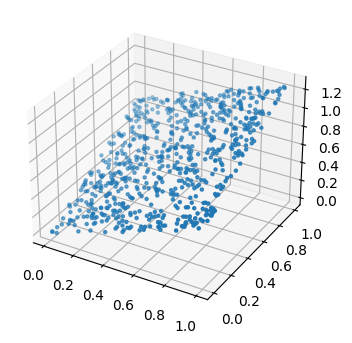

In [3]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.')
plt.show()

## Implicit Differentiation

Here we consider a linear toy example of a bilevel problem where $X_v$ is a $m_v\times n$ **validtaion set** feature matrix (every row is a feature vector of dimension $n$) and $y_v$ is an $m_v$ dimensional **validation set** true value vector (every member is the true value for a corresponding feature vector). Similarly, $X_t \in R^{m_t\times n}$ and $y \in R^{m_t}$ constitute the **training set**. We have the outer objective:
$$
  F(\mu, \theta^*) = \lVert X_v\theta^* - y_v \lVert^2
$$
and the inner objective:
$$
  s.t.\ \theta^*(x)\in \arg \min_{\theta} G(\mu, \theta) = \lVert X_t\theta - y_t \lVert^2 + \mu\lVert X_t\theta \lVert^2
$$
To use classical implicit differentiation we give a closed form solution of the lower objective $G(\mu, \theta)$ for a fixed $\mu$:

In [4]:
def find_h_star(X, y, mu):
    """
    Find a closed form solution of theta for a fixed mu.
    """
    theta = torch.linalg.inv((1+2*mu) * torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ y
    return theta

We then provide all necessary gradients to compute the gradient $\nabla_\mu F$ as functions of the parameter vector $\theta$ and the outer parameter $\mu$:

In [5]:
fo = lambda mu, h, w, v: None
fi = lambda mu, h, w, v: None
# Gradient wrt mu of f
og1 = lambda mu, h, X_out, y_out: torch.tensor([[0]])
# Gradient wrt h of f
og2 = lambda mu, h, X_out, y_out: torch.transpose(X_out,0,1) @ (X_out @ h - y_out) + torch.mul(h,torch.mul(mu,2.0))
# Hessian wrt h of g
ig22 = lambda mu, h, X_in, y_in: torch.transpose(X_in,0,1) @ X_in + torch.mul(torch.eye(len(h)),torch.mul(mu,2.0))
# Gradient wrt mu of gradient wrt h of g
ig12 = lambda mu, h, X_in, y_in: torch.mul(h,2.0)

Then we use **classical implicit differentiation** to find the optimal $\mu^*$:

In [6]:
# Optimize using neural implicit differention
bp = BilevelProblem(outer_objective=fo, inner_objective=fi, method="implicit_diff", outer_grad1=og1, outer_grad2=og2, inner_grad22=ig22, inner_grad12=ig12, find_h_star=find_h_star, X_outer=X_val, y_outer=y_val, X_inner=X_train, y_inner=y_train)
# We start so close to 0 but it still takes so many iterations to converge!
mu0 = torch.full((1,1), 1.)
mu_opt, iters, n_iters = bp.optimize(mu0, maxiter=200, step=0.1)
print("Argmin of the outer objective:", mu_opt)
print("Number of iterations:", n_iters)

Gradient: tensor([[0.1425]])
Gradient: tensor([[0.1432]])
Gradient: tensor([[0.1438]])
Gradient: tensor([[0.1445]])
Gradient: tensor([[0.1452]])
Gradient: tensor([[0.1459]])
Gradient: tensor([[0.1466]])
Gradient: tensor([[0.1473]])
Gradient: tensor([[0.1480]])
Gradient: tensor([[0.1487]])
Gradient: tensor([[0.1494]])
Gradient: tensor([[0.1501]])
Gradient: tensor([[0.1508]])
Gradient: tensor([[0.1514]])
Gradient: tensor([[0.1521]])
Gradient: tensor([[0.1528]])
Gradient: tensor([[0.1534]])
Gradient: tensor([[0.1541]])
Gradient: tensor([[0.1547]])
Gradient: tensor([[0.1553]])
Gradient: tensor([[0.1559]])
Gradient: tensor([[0.1565]])
Gradient: tensor([[0.1571]])
Gradient: tensor([[0.1576]])
Gradient: tensor([[0.1581]])
Gradient: tensor([[0.1586]])
Gradient: tensor([[0.1590]])
Gradient: tensor([[0.1594]])
Gradient: tensor([[0.1597]])
Gradient: tensor([[0.1600]])
Gradient: tensor([[0.1603]])
Gradient: tensor([[0.1605]])
Gradient: tensor([[0.1606]])
Gradient: tensor([[0.1606]])
Gradient: tens

## Neural Implicit Differentiation

To use neural implicit differentiation we reformulate the problem into a **functional bilevel problem**:
$$
  F(\mu, h^*) = \lVert h^*(X_v) - y_v \lVert^2
$$
and the inner objective:
$$
  s.t.\ h^*(x)\in \arg \min_{h\in H} G(\mu, h) = \lVert h(X_t) - y_t \lVert^2 + \mu\lVert h(X_t) \lVert^2
$$

We provide all necessary gradients to compute the gradient $\nabla_\mu F$ as functions of the function $h$ and the outer parameter $\mu$:

In [7]:
# Gradient wrt mu of f
og1 = lambda mu, h, X_out, y_out: torch.tensor([[0]])
# Gradient wrt h of f
og2 = lambda mu, h, X_out, y_out: (h(X_out) - y_out)
# Hessian wrt h of g
ig22 = lambda mu, h, X_in, y_in: torch.eye(len(y_in))
# Gradient wrt mu of gradient wrt h of g
ig12 = lambda mu, h, X_in, y_in: h(X_in) * 2

Then we use **neural implicit differentiation** to find the optimal $\mu^*$:

In [8]:
# Optimize using neural implicit differention
bp = BilevelProblem(outer_objective=fo, inner_objective=fi, method="neural_implicit_diff", outer_grad1=og1, outer_grad2=og2, inner_grad22=ig22, inner_grad12=ig12, X_outer=X_val, y_outer=y_val, X_inner=X_train, y_inner=y_train)
mu0 = torch.full((1,1), 1.)
mu_opt, iters, n_iters = bp.optimize(mu0, maxiter=200, step=0.1)
print("Argmin of the outer objective:", mu_opt)
print("Number of iterations:", n_iters)

Gradient: tensor([[0.6157]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.5848]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.4171]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.5525]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.5994]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.6923]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.6147]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.7547]], grad_fn=<AddBackward0>)
Gradient: tensor([[0.7442]], grad_fn=<AddBackward0>)
Gradient: tensor([[1.0140]], grad_fn=<AddBackward0>)
Gradient: tensor([[1.0776]], grad_fn=<AddBackward0>)
Gradient: tensor([[1.4228]], grad_fn=<AddBackward0>)
Gradient: tensor([[3.3922]], grad_fn=<AddBackward0>)
Gradient: tensor([[4.6225]], grad_fn=<AddBackward0>)
Argmin of the outer objective: tensor([[0.]])
Number of iterations: 14
